In [92]:
import numpy as np
import pandas as pd
import seaborn as sb

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import random

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc
from matplotlib.pylab import rcParams

import time

import graphviz

import os

os.environ["PATH"]+=os.pathsep+"C:\Program Files (x86)/Graphviz2.38/bin/"

font_path="C:/Windows/Fonts/gulim.ttc"
font_name=mpl.font_manager.FontProperties(fname=font_path).get_name()
mpl.rc("font", family=font_name)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [93]:
data=pd.read_csv("D:/☆디지털혁신팀/☆분양가 분석/☆데이터/흥덕구+서원구_실거래가 전처리 완료_200603.csv", thousands=",", encoding="Ansi")

data["area"]=data["area"].astype(int)

data=data.sort_values(by=["id", "area", "floor"], ascending=True, na_position="first", axis=0)

data=data.set_index(["id", "name"])

data=data.drop(["address1", "address2", "built", "built_tf", "company", "company1", "company2", "brand", "brand_boolean", "brand_label", "heating", "heating_label", "type", "fuel", "elem", "trade", "trade_tf", "money"], axis=1)
data=data.drop(["lat", "lon", "lotte1", "cgv1", "homeplus", "cju", "cinema", "elec", "lotte2", "cgv2","airport", "factory"], axis=1)

data=data.fillna(-1)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 39947 entries, (7200, '대림가경') to (118823, '강내두진하트리움')
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   buildings      39947 non-null  int64  
 1   houses         39947 non-null  int64  
 2   lowest         39947 non-null  int64  
 3   highest        39947 non-null  int64  
 4   built_year     39947 non-null  int64  
 5   built_month    39947 non-null  int64  
 6   trade_year     39947 non-null  int64  
 7   trade_month    39947 non-null  int64  
 8   age            39947 non-null  int64  
 9   ratio1         39947 non-null  int64  
 10  ratio2         39947 non-null  int64  
 11  parking        39947 non-null  float64
 12  company_label  39947 non-null  float64
 13  brand_rank     39947 non-null  float64
 14  type_label     39947 non-null  int64  
 15  fuel_label     39947 non-null  int64  
 16  elem_label     39947 non-null  float64
 17  min_elem       39947 n

### hyperparameters tunning

In [94]:
names=list(set(data.index))
random.shuffle(names)

names
# print(names.index((11566, '옥산금정2차')))
# print(names.index((17228, '아트빌')))

[(7265, '두산한솔1차'),
 (7206, '동부'),
 (26052, '가경주공2단지'),
 (11566, '옥산금정2차'),
 (26632, '오송힐데스하임'),
 (7335, '세원느티마을'),
 (15438, '삼일(3034)'),
 (15475, '한성'),
 (7283, '송학삼익맨션'),
 (7350, '형석(992)'),
 (105262, '덕성'),
 (9980, '삼정백조'),
 (7487, '주공2단지'),
 (7300, '삼익세라믹'),
 (7401, '산남세원청실'),
 (13149, '덕일'),
 (13988, '보성'),
 (7324, '삼일(2008)'),
 (7482, '비하효성2차'),
 (7485, '우성2차'),
 (13906, '삼정백조'),
 (15370, '강내태암수정'),
 (114461, '청주가경아이파크'),
 (106972, '복대두진하트리움'),
 (7478, '효성1차'),
 (7459, '진양'),
 (26494, '대주피오레2차'),
 (103456, '청주비하계룡리슈빌2차'),
 (106825, '푸르지오캐슬5단지'),
 (15368, '선광한빛'),
 (7222, '가경신라'),
 (13560, '아름다운나날2차'),
 (7303, '삼호'),
 (26806, '구룡산휴먼시아3단지'),
 (12787, '한마음2차'),
 (113572, '청주복대두진하트리움2차'),
 (25551, '유승한내들'),
 (11555, '벽산'),
 (15426, '청도'),
 (7461, '형석'),
 (12983, '청주개신푸르지오'),
 (115428, '청주테크노폴리스푸르지오'),
 (115388, '청주테크노폴리스우방아이유쉘1단지'),
 (12832, '영조아름다운나날1차'),
 (7500, '주공5단지'),
 (7390, '현대(227-2)'),
 (26882, '가로수마을선광로즈웰'),
 (24345, '대원칸타빌'),
 (25917, '대원칸타빌1단지'),
 (7267, '두산한솔2차'),
 (2705

In [115]:
num=12
def objective(pred, dtrain):
    observed = dtrain.get_label()
    grad = np.power(pred - observed, num - 1)
    hess = np.power(pred - observed, num - 2)
    return grad, hess
def metric(pred, dtrain):
    observed = dtrain.get_label()
    return "error", (pred - observed)/(len(observed), 1/num)

In [116]:
params={"eta":0.02, "max_depth":6, "min_child_weight":5, "gamma":1, "subsample":0.5, "colsample_bytree":1, "reg_alpha":0.1, "n_jobs":6}
num_rounds=1000

time_before=round(time.time())

test_X_concat=pd.DataFrame()
test_y_concat=pd.DataFrame()
split=5
for i in range(split):
    names_test=names[int(len(names)/split*i):int(len(names)/split*(i+1))]
    
    test=data.loc[data.index.isin(names_test)]
    test_X=test.drop(["ppa"], axis=1)
    test_y=pd.DataFrame(test[["ppa"]])

    train_val=data.loc[~data.index.isin(names_test)]
    train_val_X=train_val.drop(["ppa"], axis=1)
    train_val_y=pd.DataFrame(train_val[["ppa"]])

    train_X, val_X, train_y, val_y=train_test_split(train_val_X, train_val_y, train_size=0.7, shuffle=True, random_state=np.random.randint(1, 100))
    
    dtrain=xgb.DMatrix(data=train_X, label=train_y, missing=-1, nthread=-1)
    dtest=xgb.DMatrix(data=test_X, label=test_y, missing=-1, nthread=-1)
    watchlist=[(dtrain, "train"), (dtest,"val")]
    
    model=xgb.train(params=params, dtrain=dtrain, evals=watchlist, num_boost_round=num_rounds, early_stopping_rounds=10, obj=objective, feval=metric)
#     model.fit(train_X, train_y,eval_set=[(train_X, train_y), (val_X, val_y)], early_stopping_rounds=50, verbose=True)

    test_y["pred"]=model.predict(dtest)
    test_y["error"]=round((abs(test_y["pred"]-test_y["ppa"])/test_y["ppa"])*100, 2)
# mse=((mean_squared_error(pred, np.array(test_y)))/len(test)).round(0)

    test_X_concat=pd.concat([test_X_concat, test_X], axis=0)
    test_y_concat=pd.concat([test_y_concat, test_y], axis=0)

mean=np.array(test_y_concat["error"]).mean().round(1)
std=np.array(test_y_concat["error"]).std().round(1)

print("{}초 경과".format(round(time.time())-time_before))
print("오차율(%)의 평균 :", mean, "표준편차 :", std)

[0]	train-rmse:262.88922	val-rmse:233.08603	train-error:347.41167	val-error:322.39640
Multiple eval metrics have been passed: 'val-error' will be used for early stopping.

Will train until val-error hasn't improved in 10 rounds.
[1]	train-rmse:257.09604	val-rmse:227.76491	train-error:340.50607	val-error:316.93861
[2]	train-rmse:251.37962	val-rmse:222.48039	train-error:333.78086	val-error:311.56877
[3]	train-rmse:245.78505	val-rmse:217.31764	train-error:327.23061	val-error:306.29908
[4]	train-rmse:240.34862	val-rmse:212.38660	train-error:320.83948	val-error:301.18784
[5]	train-rmse:234.99521	val-rmse:207.44220	train-error:314.45580	val-error:296.03193
[6]	train-rmse:229.71626	val-rmse:202.63469	train-error:308.40061	val-error:291.88154
[7]	train-rmse:224.62401	val-rmse:197.87424	train-error:302.29889	val-error:286.29489
[8]	train-rmse:219.62875	val-rmse:193.23389	train-error:296.27769	val-error:280.69601
[9]	train-rmse:214.65921	val-rmse:188.59053	train-error:290.48638	val-error:275.859

[95]	train-rmse:25.30001	val-rmse:31.55567	train-error:55.67362	val-error:83.18729
[96]	train-rmse:24.90539	val-rmse:31.58478	train-error:54.65946	val-error:82.60308
[97]	train-rmse:24.49702	val-rmse:31.37327	train-error:53.63484	val-error:81.64878
[98]	train-rmse:24.10645	val-rmse:31.24273	train-error:52.72032	val-error:80.92914
[99]	train-rmse:23.70931	val-rmse:31.21507	train-error:51.81653	val-error:80.72749
[100]	train-rmse:23.33923	val-rmse:31.00552	train-error:50.86330	val-error:79.96294
[101]	train-rmse:22.99225	val-rmse:30.88414	train-error:50.07901	val-error:79.21163
[102]	train-rmse:22.66388	val-rmse:30.74514	train-error:49.34123	val-error:78.21881
[103]	train-rmse:22.37288	val-rmse:30.53248	train-error:48.49130	val-error:77.49811
[104]	train-rmse:22.07337	val-rmse:30.55634	train-error:47.83008	val-error:76.83950
[105]	train-rmse:21.73196	val-rmse:30.55609	train-error:47.06773	val-error:76.07697
[106]	train-rmse:21.43599	val-rmse:30.37351	train-error:46.32750	val-error:75.402

[25]	train-rmse:145.04074	val-rmse:154.20760	train-error:216.30585	val-error:197.77174
[26]	train-rmse:141.54334	val-rmse:150.72082	train-error:212.05514	val-error:194.16719
[27]	train-rmse:138.19890	val-rmse:147.42197	train-error:207.96788	val-error:190.82704
[28]	train-rmse:134.91815	val-rmse:144.15909	train-error:203.94834	val-error:187.57289
[29]	train-rmse:131.66562	val-rmse:140.93343	train-error:199.95537	val-error:184.22570
[30]	train-rmse:128.49722	val-rmse:137.80328	train-error:196.22178	val-error:181.10008
[31]	train-rmse:125.40260	val-rmse:134.64250	train-error:192.42080	val-error:177.79514
[32]	train-rmse:122.31992	val-rmse:131.52026	train-error:188.62616	val-error:174.36423
[33]	train-rmse:119.33247	val-rmse:128.58926	train-error:184.91293	val-error:171.12527
[34]	train-rmse:116.44221	val-rmse:125.68189	train-error:181.37923	val-error:167.93558
[35]	train-rmse:113.61961	val-rmse:122.87554	train-error:177.92241	val-error:164.89479
[36]	train-rmse:110.80512	val-rmse:120.0546

[123]	train-rmse:19.08524	val-rmse:29.13485	train-error:39.53248	val-error:67.39090
[124]	train-rmse:19.03870	val-rmse:29.11381	train-error:39.17234	val-error:67.55046
[125]	train-rmse:18.97364	val-rmse:29.02072	train-error:38.91255	val-error:67.66360
[126]	train-rmse:18.92741	val-rmse:28.99666	train-error:38.77837	val-error:68.01860
[127]	train-rmse:19.00417	val-rmse:29.17800	train-error:38.35950	val-error:67.92162
[128]	train-rmse:19.05169	val-rmse:29.30346	train-error:37.93369	val-error:67.60397
[129]	train-rmse:19.01472	val-rmse:29.30001	train-error:37.76232	val-error:67.30248
[130]	train-rmse:18.90957	val-rmse:29.16202	train-error:37.48524	val-error:67.57556
Stopping. Best iteration:
[120]	train-rmse:19.49220	val-rmse:29.41696	train-error:40.36397	val-error:66.74144

[0]	train-rmse:262.18549	val-rmse:241.74991	train-error:352.34947	val-error:303.64755
Multiple eval metrics have been passed: 'val-error' will be used for early stopping.

Will train until val-error hasn't improved in

[85]	train-rmse:31.79064	val-rmse:34.28344	train-error:67.69341	val-error:118.93102
[86]	train-rmse:31.12358	val-rmse:34.08955	train-error:66.44642	val-error:119.48049
[87]	train-rmse:30.45156	val-rmse:33.94356	train-error:65.21284	val-error:120.13465
[88]	train-rmse:29.87654	val-rmse:33.84168	train-error:63.99307	val-error:119.38380
[89]	train-rmse:29.24425	val-rmse:33.79449	train-error:62.80816	val-error:120.02198
[90]	train-rmse:28.62892	val-rmse:33.55612	train-error:61.65660	val-error:119.25027
[91]	train-rmse:28.01926	val-rmse:33.60902	train-error:60.50440	val-error:119.86852
[92]	train-rmse:27.46298	val-rmse:33.56090	train-error:59.45878	val-error:119.20956
Stopping. Best iteration:
[82]	train-rmse:34.30225	val-rmse:34.92862	train-error:71.61666	val-error:116.98471

[0]	train-rmse:261.78055	val-rmse:247.79437	train-error:353.25598	val-error:292.66672
Multiple eval metrics have been passed: 'val-error' will be used for early stopping.

Will train until val-error hasn't improved in

[86]	train-rmse:31.47004	val-rmse:32.89248	train-error:67.46404	val-error:76.85057
[87]	train-rmse:30.71818	val-rmse:32.52938	train-error:66.38144	val-error:77.04471
[88]	train-rmse:30.00767	val-rmse:32.45831	train-error:65.29387	val-error:77.46658
[89]	train-rmse:29.39975	val-rmse:32.23356	train-error:64.04856	val-error:77.97976
[90]	train-rmse:28.71332	val-rmse:32.04266	train-error:62.79561	val-error:78.56948
[91]	train-rmse:28.16222	val-rmse:31.79240	train-error:61.78686	val-error:79.17890
Stopping. Best iteration:
[81]	train-rmse:35.47372	val-rmse:35.13799	train-error:74.16289	val-error:76.01291

[0]	train-rmse:248.73145	val-rmse:285.95886	train-error:306.83537	val-error:385.31063
Multiple eval metrics have been passed: 'val-error' will be used for early stopping.

Will train until val-error hasn't improved in 10 rounds.
[1]	train-rmse:243.30486	val-rmse:280.22946	train-error:300.77601	val-error:380.53396
[2]	train-rmse:237.96475	val-rmse:274.46649	train-error:294.83282	val-error:3

[87]	train-rmse:28.76372	val-rmse:51.13830	train-error:56.93327	val-error:149.98047
[88]	train-rmse:28.12935	val-rmse:50.49503	train-error:55.89016	val-error:149.07197
[89]	train-rmse:27.54204	val-rmse:49.74076	train-error:54.94536	val-error:148.15148
[90]	train-rmse:26.95533	val-rmse:49.09546	train-error:54.18324	val-error:147.18601
[91]	train-rmse:26.40173	val-rmse:48.44125	train-error:53.22080	val-error:146.34351
[92]	train-rmse:25.83703	val-rmse:47.87053	train-error:52.50149	val-error:145.42272
[93]	train-rmse:25.36589	val-rmse:47.38391	train-error:52.00151	val-error:144.63286
[94]	train-rmse:24.93098	val-rmse:46.81008	train-error:51.45436	val-error:143.83869
[95]	train-rmse:24.54024	val-rmse:46.31434	train-error:50.73481	val-error:142.91857
[96]	train-rmse:24.08520	val-rmse:45.83060	train-error:50.13128	val-error:142.08680
[97]	train-rmse:23.70639	val-rmse:45.45461	train-error:49.90494	val-error:141.41096
[98]	train-rmse:23.42046	val-rmse:45.16372	train-error:49.36666	val-error:14

In [5]:
model=xgb.XGBRegressor(booster="gbtree", max_delta_step=0, importance_type='gain', missing=-1, n_jobs=5, reg_lambda=1, scale_pos_weight=1, seed=None, base_score=0.5, verbosity=1, warning="ignore", silent=0)
model.eta=0.01
model.n_estimators=1000
model.max_depth=6
model.min_child_weight=5
model.gamma=1
model.subsample=0.5
model.colsample_bytree=1
model.reg_alpha=0.1
model.objective = custom_se
model.n_jobs=5

time_before=round(time.time())

test_X_concat=pd.DataFrame()
test_y_concat=pd.DataFrame()
split=5
for i in range(split):
    names_test =names[int(len(names)/split*i):int(len(names)/split*(i+1))]
    
    test=data.loc[data.index.isin(names_test)]
    test_X=test.drop(["ppa"], axis=1)
    test_y=pd.DataFrame(test[["ppa"]])

    train_val=data.loc[~data.index.isin(names_test)]
    train_val_X=train_val.drop(["ppa"], axis=1)
    train_val_y=pd.DataFrame(train_val[["ppa"]])

    train_X, val_X, train_y, val_y=train_test_split(train_val_X, train_val_y, train_size=0.7, shuffle=True, random_state=np.random.randint(1, 100))
    
    model.fit(train_X, train_y, eval_set=[(train_X, train_y), (val_X, val_y)], early_stopping_rounds=50, verbose=True) #'early_stopping_rounds' 만큼 epoch당 학습 성능이 나아지지 않으면 early stopping함

    test_y["pred"]=model.predict(test_X).round(1)
    test_y["error"]=round((abs(test_y["pred"]-test_y["ppa"])/test_y["ppa"])*100, 2)
# mse=((mean_squared_error(pred, np.array(test_y)))/len(test)).round(0)

    test_X_concat=pd.concat([test_X_concat, test_X], axis=0)
    test_y_concat=pd.concat([test_y_concat, test_y], axis=0)

mean=np.array(test_y_concat["error"]).mean().round(1)
std=np.array(test_y_concat["error"]).std().round(1)

print("{}초 경과".format(round(time.time())-time_before))
print("오차율(%)의 평균 :", mean, "표준편차 :", std)

SyntaxError: invalid syntax (<ipython-input-5-28783c612876>, line 8)

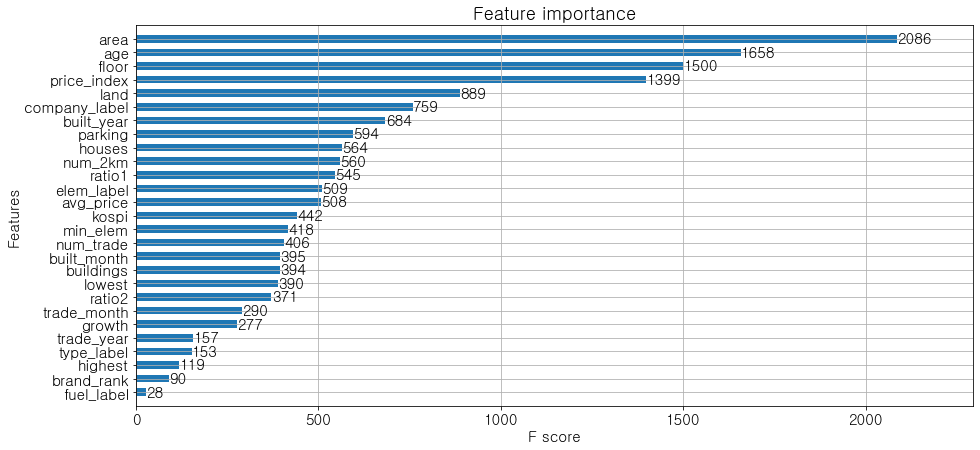

In [103]:
rcParams["figure.figsize"]=(15, len(train_X.columns)/4)
plt.rcParams["font.size"]=15
xgb.plot_importance(model, height=len(train_X.columns)/50)

plt.savefig("D:/☆디지털혁신팀/☆분양가 분석/☆그래프/feature importance_200607.png", bbox_inches="tight")

### plot feature importance

In [9]:
def plot_tree(xgb_model,filename,rankdir='UT'):
    import os
    gvz=xgb.to_graphviz(xgb_model,num_trees=xgb_model.best_iteration,rankdir=rankdir)
    _,file_extension=os.path.splitext(filename)
    format=file_extension.strip(".").lower()
    data=gvz.pipe(format=format)
    full_filename=filename
    with open(full_filename,"wb") as f:
        f.write(data)
        
plot_tree(model,"D:/☆디지털혁신팀/☆분양가 분석/☆그래프/흥덕구+서원구_plot_tree_200604.pdf")

### save error results and plot stripplot for error

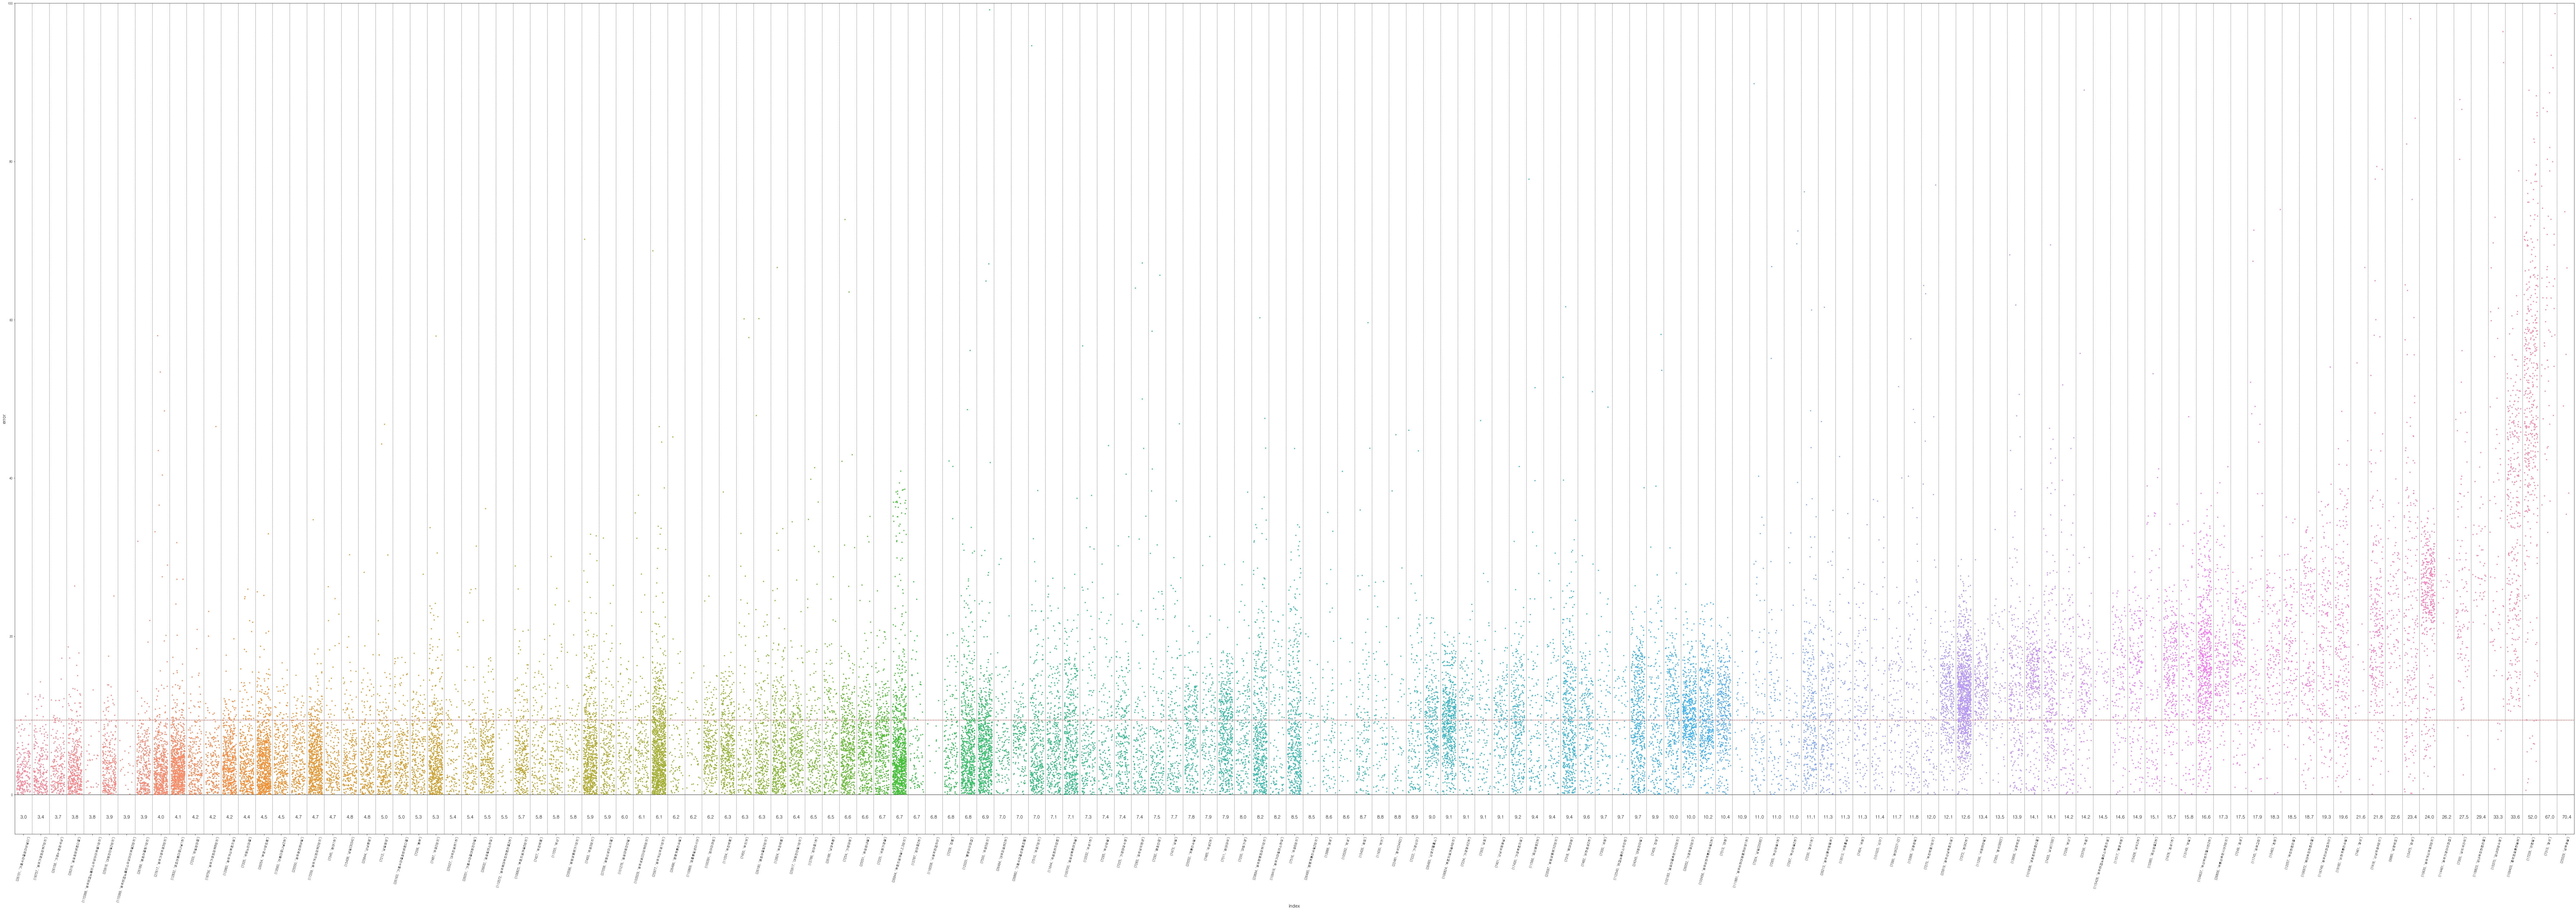

In [102]:
results=pd.concat([test_X_concat, test_y_concat], axis=1)

results_groupby=results.groupby(results.index).mean()

results_groupby_order=results_groupby.sort_values(by=["error"], ascending=True, na_position="first", axis=0)

order=results_groupby_order.index.tolist()

results.index=pd.Categorical(results.index, categories=order)
results_order=results.sort_index()
results_order=results_order.reset_index()

results_order.to_csv("D:/☆디지털혁신팀/☆분양가 분석/☆그래프/results_200607_2승.csv", encoding="euc-kr")

xx=results_order["index"]
yy=results_order["error"]

plt.figure(figsize=(len(xx.unique()), len(xx.unique())/3))
plt.ylim(-5, 100)
plt.xticks(rotation=75)
plt.xlabel("ID 및 단지명", fontsize=15)
plt.ylabel("오차율(%)",fontsize=15)

graph=sb.stripplot(x=xx, y=yy, data=results_order, jitter=0.4, edgecolor="gray", size=4)

plt.axhline(y=mean, color='r', linestyle=':', linewidth=2)
plt.axhline(y=0, color='k', linewidth=1)

for i in range(len(order)):
    plt.axvline(x=i+0.5, color='k', linestyle=':',linewidth=1)
    plt.text(x=i-0.2, y=-3, s=pd.DataFrame(results_groupby_order["error"]).iloc[i, 0].round(1), fontsize=15)

graph.figure.savefig("D:/☆디지털혁신팀/☆분양가 분석/☆그래프/errors_stripplot_200607_2승.png", bbox_inches="tight")

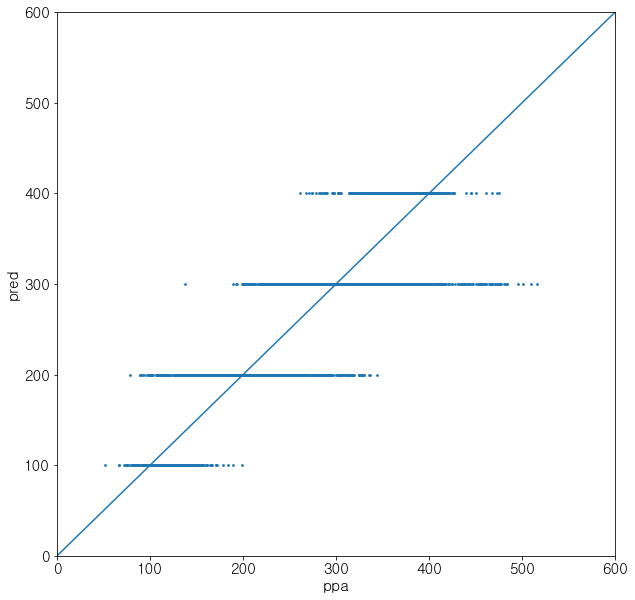

In [9]:
plt.figure(figsize=(10,10))
plt.axis([0, 600, 0, 600])
plt.scatter(test_y["ppa"], test_y["pred"], s=3)
plt.xlabel("ppa")
plt.ylabel("pred")
a=range(0,2000)
b=range(0,2000)
plt.plot(a,b)